# Importando as bibliotecas

In [ ]:
import pandas as pd
from db import connection_db as conndb
from db import filters
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from utils.estracao_interacao import ExtracaoInteracao
from utils.text_treatment import TextTreatment
from utils.busca_palavras import BuscaPalavras

tqdm.pandas()

Conectando ao banco de dados do MongoDB

In [ ]:
uri = 'mongodb://localhost:27017/'
db_name = 'dadosVivamente'
col_name = 'dadosSemFiltros'

mongo_connection = conndb.MongoDBConnection(uri=uri, database_name=db_name, collection_name=col_name)
mongo_connection.connect()
collection = mongo_connection.collection

Aplicando pipeline para preparação dos dados

In [ ]:
collection_filters = filters.CollectionFilters(collection)

# Aplicando pipeline 1
collection_filters.apply_pipeline1('dadosComFiltrosIniciais')

# Aplicando pipeline 2 - pega os posts que tenha a data de publicação de no máximo 7 anos e no mínimo 2 anos
collection_filters.apply_pipeline2(7, 1, 'posts7anos1anos')

# Aplicando pipeline 3 - desenrola os posts em documentos individuais e cria novas colunas
collection_filters.apply_pipeline3('postsComBDIAndInfos')

# Aplicando pipeline 4 - aplica o filtro para selecionar apenas os posts que tem uma data de publicação válida
collection_filters.apply_pipeline4('postsComBDIAndInfosFiltroDataPosts')

collection = collection_filters.collection

In [ ]:
documentos = collection.find()
df_original = pd.DataFrame(list(documentos))

# Visualizar as primeiras linhas do dataframe
df_original.head()

In [ ]:
# Lista de colunas que precisam ser convertidas
colunas_para_converter = [
    'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima',
    'critica', 'suicida', 'choro', 'agitacao', 'interesse', 'indecisao',
    'desvalorizacao', 'energia', 'sono', 'irritabilidade', 'apetite',
    'concentracao', 'fadiga', 'int_sexo', 'quantAmigos'
]


# Função para preencher valores nulos e converter o tipo de dado
def preencher_e_converter(df, colunas, valor_preenchimento=0, tipo_dados='int64'):
    df[colunas] = df[colunas].fillna(valor_preenchimento)
    df[colunas] = df[colunas].astype(tipo_dados)
    return df


# Aplicando a função
df_original = preencher_e_converter(df_original, colunas_para_converter)

# Filtragem dos dados
df_original.drop(columns=['_id', 'diaDaSemana', 'hora', 'minutos', 'diaDoMes', 'mes', 'ano'], inplace=True)

# Criando novas colunas com o pandas
df_original['data'] = df_original['postCreatedTime'].dt.date
df_original['data'] = pd.to_datetime(df_original['data'])
df_original['mes'] = df_original['data'].dt.to_period('M')
df_original['semana'] = df_original['data'].dt.to_period('W')

# Filtrar posts do ano de 2016
df_2017 = df_original[df_original['data'].dt.year == 2017]
df_2017 = df_2017[~((df_2017['data'].dt.month == 12) & (df_2017['data'].dt.year == 2017))]
df_2017 = df_2017[df_2017['data'].dt.month >= 5]
df_2017 = df_2017[df_2017['suicida'] == 3]
df_2017 = df_2017

# Remover linhas onde ambas as colunas 'postMessage' e 'postStory' estão vazias ou nulas
df_2017 = df_2017.dropna(subset=['postMessage', 'postStory'], how='all')  # Remove quando ambas são NaN
df_2017 = df_2017[~((df_2017['postMessage'].str.strip() == '') & (
        df_2017['postStory'].str.strip() == ''))]  # Remove quando ambas são strings vazias

In [ ]:
# Adicionando novas features
extracao = ExtracaoInteracao(df_2017)
df_interacoes = extracao.extract_interactions()

# Passo 6: Modificar outras colunas usando .loc para evitar avisos
df_interacoes['sexo'] = df_interacoes['sexo'].map({'F': 0, 'M': 1})

tratamento_texto = TextTreatment()
df_interacoes['postMessageLimpo'] = df_interacoes['postMessage'].fillna('').progress_apply(
    lambda texto: tratamento_texto.preprocessamento_texto(texto) if texto else '')

busca_palavras = BuscaPalavras()

# Faz a busca exata
resultado = busca_palavras.string_matching(df_interacoes['postMessageLimpo'],
                                           'dados/datasets/termos_depressivos_pt_br.txt')

# Adicionar a coluna quantPalavrasDepressivas ao DataFrame, contando quantas palavras depressivas foram encontradas
df_interacoes['quantPalavrasDepressivas'] = resultado.apply(lambda x: len(x.split(', ')) if x else 0)
df_interacoes.head()

In [ ]:
# Criar um dataframe para conter as colunas que não mudam e o id_usuario
df_respostas_bdi = df_interacoes.groupby(['id_usuario']).agg(
    idade=('idade', 'first'),
    sexo=('sexo', 'first'),
    quantAmigos=('quantAmigos', 'first'),
    nivel=('nivel', 'first'),
    pessimismo=('pessimismo', 'first'),
    tristeza=('tristeza', 'first'),
    fracasso=('fracasso', 'first'),
    prazer=('prazer', 'first'),
    culpa=('culpa', 'first'),
    punicao=('punicao', 'first'),
    estima=('estima', 'first'),
    critica=('critica', 'first'),
    suicida=('suicida', 'first'),
    choro=('choro', 'first'),
    agitacao=('agitacao', 'first'),
    interesse=('interesse', 'first'),
    indecisao=('indecisao', 'first'),
    desvalorizacao=('desvalorizacao', 'first'),
    energia=('energia', 'first'),
    sono=('sono', 'first'),
    irritabilidade=('irritabilidade', 'first'),
    apetite=('apetite', 'first'),
    concentracao=('concentracao', 'first'),
    fadiga=('fadiga', 'first'),
    int_sexo=('int_sexo', 'first'),
).reset_index()

# Visualizar as primeiras linhas do dataframe
df_respostas_bdi.head()

In [ ]:
df_interacoes.drop(
    columns=['idade', 'sexo', 'quantAmigos', 'nivel', 'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa',
             'punicao', 'estima', 'critica', 'suicida', 'choro', 'agitacao', 'interesse', 'indecisao', 'desvalorizacao',
             'energia', 'sono', 'irritabilidade', 'apetite', 'concentracao', 'fadiga', 'int_sexo'], inplace=True)

In [ ]:
df_interacoes.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvnmddiu1/mntglszq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvnmddiu1/zysl9zl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/paulovss/Documentos/projects/python/analise_dados/venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80834', 'data', 'file=/tmp/tmpvnmddiu1/mntglszq.json', 'init=/tmp/tmpvnmddiu1/zysl9zl_.json', 'output', 'file=/tmp/tmpvnmddiu1/prophet_modelqpb34iwa/prophet_model-20240926112513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done p

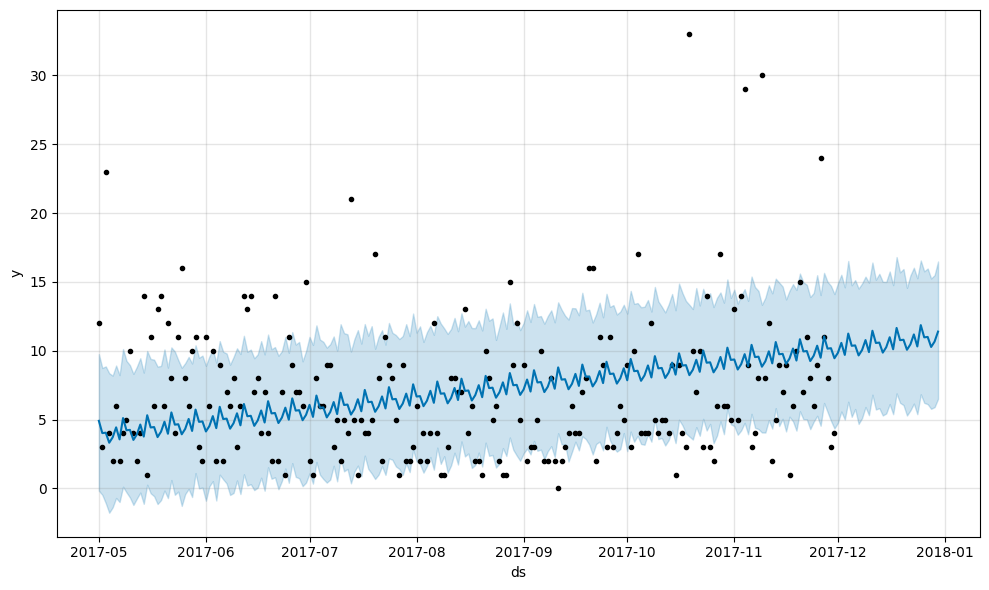

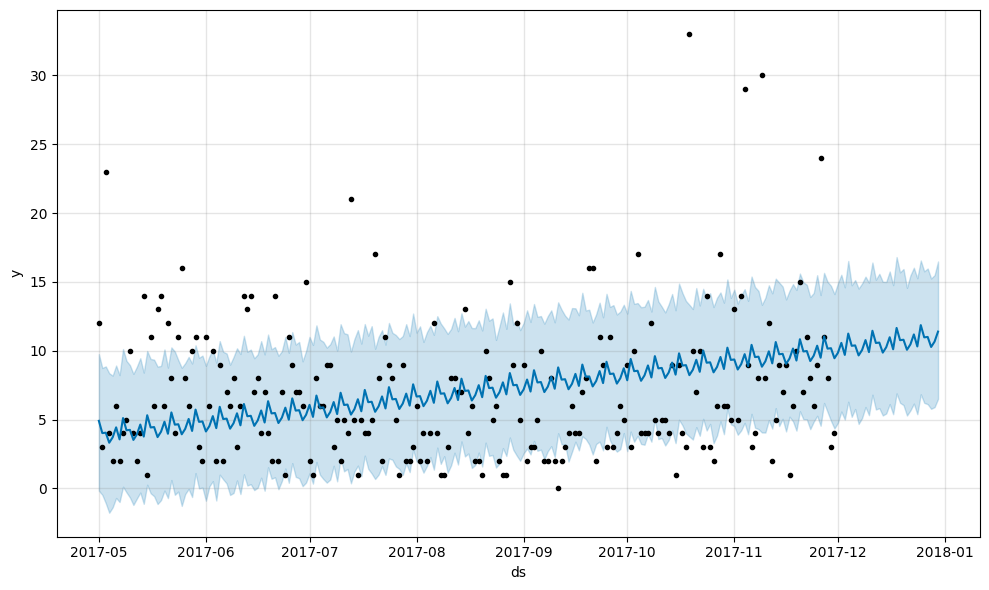

In [11]:
from prophet import Prophet

# Codificar 'id_usuario' com one-hot encoding
user_dummies = pd.get_dummies(df_interacoes['id_usuario'], prefix='user')

# Combinar as dummies com o DataFrame original
df_prophet = pd.concat([df_interacoes, user_dummies], axis=1)

# Lista de colunas a serem agregadas (incluindo as dummies)
aggregate_cols = ['quantPalavrasDepressivas'] + user_dummies.columns.tolist()

# Agrupar por data, somando as colunas
df_grouped = df_prophet.groupby('data')[aggregate_cols].sum().reset_index()

# Renomear colunas para o Prophet
df_grouped.rename(columns={'data': 'ds', 'quantPalavrasDepressivas': 'y'}, inplace=True)

# Inicializar o modelo Prophet
model = Prophet()

# Adicionar cada dummy de usuário como regressora
regressors = user_dummies.columns.tolist()
for regressor in regressors:
    model.add_regressor(regressor)

# Ajustar o modelo
model.fit(df_grouped[['ds', 'y'] + regressors])

# Criar DataFrame futuro
future = model.make_future_dataframe(periods=30)

# Adicionar regressores ao DataFrame futuro
# Aqui, usamos as médias históricas como estimativas para os regressores futuros
for regressor in regressors:
    future[regressor] = df_grouped[regressor].mean()

# Fazer previsões
forecast = model.predict(future)

# Visualizar previsões
model.plot(forecast)